## Experiment on humanresources scheme

In [292]:
import matplotlib.pyplot as plt
import numpy as np

### Connect to the database

In [293]:
%run connection.ipynb

Connecting with connection string : postgresql://postgres:letmein@db:5432/Adventureworks
 * postgresql://postgres:***@db:5432/Adventureworks
1 rows affected.
 * postgresql://postgres:***@db:5432/Adventureworks
1 rows affected.
 * postgresql://postgres:***@db:5432/Adventureworks
68 rows affected.


### Create base materialized view

In [294]:
%%sql

DROP MATERIALIZED VIEW IF EXISTS humanresources.deparment_name_and_groups;

CREATE MATERIALIZED VIEW humanresources.deparment_name_and_groups AS (
    SELECT
        e.businessentityid,
        e.jobtitle,
        e.gender,
        d.departmentid,
        d.name AS deparment_name,
        d.groupname AS deparment_group_name

    FROM
        humanresources.employee e
        INNER JOIN humanresources.employeedepartmenthistory edh ON edh.businessentityid = e.businessentityid
        INNER JOIN humanresources.department d ON d.departmentid = edh.departmentid

    ORDER BY 1
)


 * postgresql://postgres:***@db:5432/Adventureworks
Done.
296 rows affected.


""


### What are the main departmant group names?

In [295]:
%%sql 

SELECT t.* FROM (
    SELECT
        bt.deparment_group_name,
        row_number() OVER(partition BY bt.deparment_group_name ORDER BY bt.businessentityid) AS row_number
    FROM humanresources.deparment_name_and_groups bt
) t WHERE t.row_number = 1

 * postgresql://postgres:***@db:5432/Adventureworks
6 rows affected.


,deparment_group_name,row_number
0,Executive General and Administration,1
1,Inventory Management,1
2,Manufacturing,1
3,Quality Assurance,1
4,Research and Development,1
5,Sales and Marketing,1


### What are the main departmant names?

In [296]:
%%sql 

SELECT t.* FROM (
    SELECT
        bt.deparment_name,
        row_number() OVER(partition BY bt.deparment_name ORDER BY bt.businessentityid) AS row_number
    FROM humanresources.deparment_name_and_groups bt
) t WHERE t.row_number = 1

 * postgresql://postgres:***@db:5432/Adventureworks
16 rows affected.


,deparment_name,row_number
0,Document Control,1
1,Engineering,1
2,Executive,1
3,Facilities and Maintenance,1
4,Finance,1
5,Human Resources,1
6,Information Services,1
7,Marketing,1
8,Production,1
9,Production Control,1


### What is gender distribution in the company?

In [297]:
%%sql

SELECT
    dnag.gender,
    COUNT(dnag.gender),
    row_number() over(PARTITION BY COUNT(dnag.gender))
FROM humanresources.deparment_name_and_groups dnag
GROUP BY 1

 * postgresql://postgres:***@db:5432/Adventureworks
2 rows affected.


,gender,count,row_number
0,F,87,1
1,M,209,1


### What is the gender distribution by deparment groups?

In [298]:
%%sql gender_distribution_by_deparment_groups_df <<

SELECT
    dnag.deparment_group_name,
    (
        SELECT COUNT(dnag2.gender) FROM humanresources.deparment_name_and_groups dnag2
        WHERE dnag2.gender = 'M' AND dnag2.deparment_group_name = dnag.deparment_group_name
    ) AS male,
    (
        SELECT COUNT(dnag3.gender) FROM humanresources.deparment_name_and_groups dnag3
        WHERE dnag3.gender = 'F' AND dnag3.deparment_group_name = dnag.deparment_group_name
    ) AS female
FROM humanresources.deparment_name_and_groups dnag
GROUP BY 1,2

 * postgresql://postgres:***@db:5432/Adventureworks
6 rows affected.
Returning data to local variable gender_distribution_by_deparment_groups_df


In [299]:
gender_distribution_by_deparment_groups_df

,deparment_group_name,male,female
0,Executive General and Administration,21,15
1,Inventory Management,13,6
2,Manufacturing,140,46
3,Quality Assurance,10,2
4,Research and Development,9,6
5,Sales and Marketing,16,12


/tmp/ipykernel_9332/540400835.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


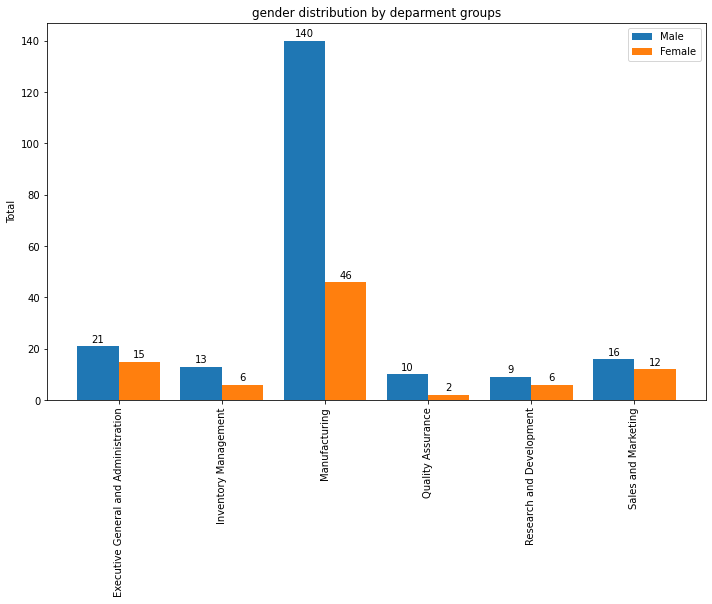

In [300]:
fig, ax = plt.subplots(figsize=(10, 6))

male = gender_distribution_by_deparment_groups_df['male']
female = gender_distribution_by_deparment_groups_df['female']

labels = gender_distribution_by_deparment_groups_df['deparment_group_name']

x = np.arange(len(labels))
width = 0.4

rects_male = ax.bar(x - width/2, male, width, label='Male')
rects_female = ax.bar(x + width/2, female, width, label='Female')

ax.set_ylabel('Total')
ax.set_title('gender distribution by deparment groups')
ax.set_xticklabels(labels)
ax.set_xticks(x)
ax.legend()

ax.bar_label(rects_male, padding=2)
ax.bar_label(rects_female, padding=2)

fig.tight_layout()
plt.xticks(rotation=90)

plt.show()

### How many employees work in each department?

In [301]:
%%sql number_of_employees_by_deparment_df <<

SELECT t.* FROM (
    SELECT
        bt.deparment_name,
        COUNT(*) AS number_of_employees,
        ROW_NUMBER() OVER(PARTITION BY bt.deparment_name ORDER BY COUNT(*) DESC) AS row_number
    FROM humanresources.deparment_name_and_groups bt
    GROUP BY 1
    ORDER BY 2 DESC
) t

WHERE t.row_number = 1

 * postgresql://postgres:***@db:5432/Adventureworks
16 rows affected.
Returning data to local variable number_of_employees_by_deparment_df


In [302]:
number_of_employees_by_deparment_df

,deparment_name,number_of_employees,row_number
0,Production,180,1
1,Sales,18,1
2,Purchasing,13,1
3,Finance,11,1
4,Information Services,10,1
5,Marketing,10,1
6,Facilities and Maintenance,7,1
7,Quality Assurance,7,1
8,Engineering,7,1
9,Shipping and Receiving,6,1


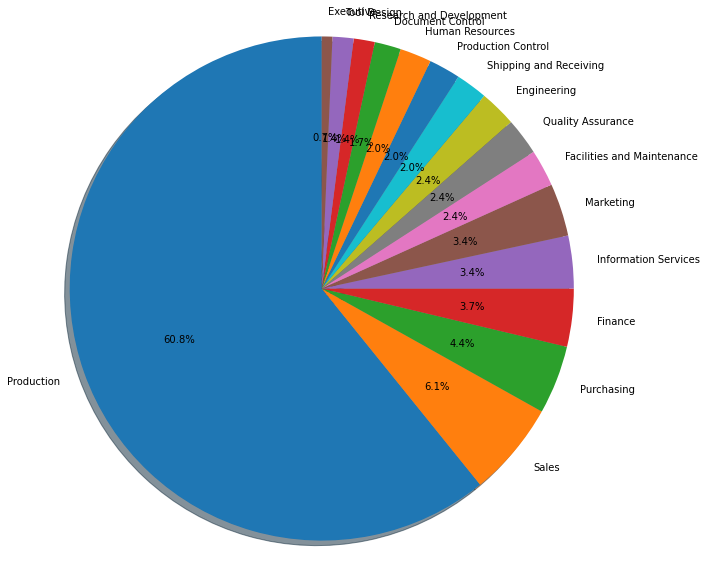

In [303]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.pie(number_of_employees_by_deparment_df['number_of_employees'],
        labels=number_of_employees_by_deparment_df['deparment_name'],
        autopct='%1.1f%%',
        shadow=True, startangle=90)
        
ax.axis('equal')

plt.show()

### What are the salary distribution by deparment?

In [304]:
%%sql salary_min_max_avg_df <<

WITH base_table AS (
    SELECT
        eph.businessentityid,
        dnag.departmentid,
        ROW_NUMBER() OVER(PARTITION BY dnag.departmentid ORDER BY dnag.departmentid) AS row_number,
        eph.rate,
        dnag.deparment_name
    FROM humanresources.employeepayhistory eph
        INNER JOIN (
            SELECT dng.businessentityid, dng.departmentid, dng.deparment_name FROM humanresources.deparment_name_and_groups dng
        ) dnag ON dnag.businessentityid = eph.businessentityid

    GROUP BY 1,2,4,5
    ORDER BY 2
)

SELECT
    bt.departmentid,
    bt.deparment_name,
    AVG(bt.rate), 
    MAX(bt.rate), 
    MIN(bt.rate)
FROM base_table bt
GROUP BY 1,2
ORDER BY 3


 * postgresql://postgres:***@db:5432/Adventureworks
16 rows affected.
Returning data to local variable salary_min_max_avg_df


In [305]:
salary_min_max_avg_df

,departmentid,deparment_name,avg,max,min
0,15,Shipping and Receiving,10.871800,19.2308,9.0000
1,14,Facilities and Maintenance,13.031600,24.0385,9.2500
2,7,Production,13.540932,84.1346,6.5000
3,12,Document Control,14.388460,17.7885,10.2500
4,8,Production Control,16.774612,24.5192,8.6200
5,13,Quality Assurance,17.238711,30.0000,9.8600
6,9,Human Resources,18.024817,27.1394,13.9423
7,4,Marketing,18.936429,37.5000,9.8600
8,5,Purchasing,20.148988,37.5000,9.8600
9,2,Tool Design,23.505400,29.8462,8.6200


/tmp/ipykernel_9332/3683125410.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


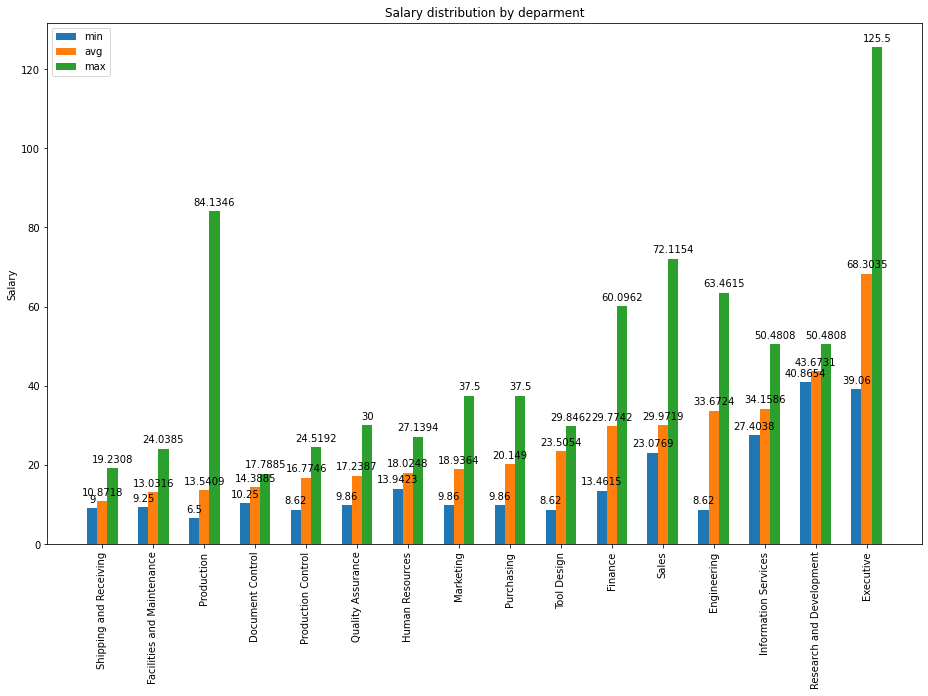

In [306]:
fig, ax = plt.subplots(figsize=(13, 8))

avg = salary_min_max_avg_df['avg']
max = salary_min_max_avg_df['max']
min = salary_min_max_avg_df['min']
labels = salary_min_max_avg_df['deparment_name']

x = np.arange(len(labels))
width = 0.2

rects_min = ax.bar(x - width, min, width, label='min')
rects_avg = ax.bar(x, avg, width, label='avg')
rects_max = ax.bar(x + width, max, width, label='max')

ax.set_ylabel('Salary')
ax.set_title('Salary distribution by deparment')
ax.set_xticklabels(labels)
ax.set_xticks(x)
ax.legend()

ax.bar_label(rects_min, padding=4)
ax.bar_label(rects_avg, padding=4)
ax.bar_label(rects_max, padding=4)

fig.tight_layout()
plt.xticks(rotation=90)

plt.show()